In [1]:
import pandas as pd 
import numpy as np 
data = pd.read_excel("未修正小区价格.xlsx")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10712 entries, 0 to 10711
Data columns (total 19 columns):
城市         10712 non-null object
行政区域       10712 non-null object
类型         10712 non-null object
小区名称       10712 non-null object
地址         10687 non-null object
所在楼层       10712 non-null int64
总楼层        10712 non-null int64
面积         10712 non-null float64
结构         10712 non-null object
建筑年代       10712 non-null int64
朝向         10712 non-null object
装修         10712 non-null object
买卖时间       10712 non-null datetime64[ns]
单价         10712 non-null float64
朝向系数       10712 non-null int64
成新系数       10712 non-null int64
结构系数       10712 non-null int64
面积系数       10712 non-null int64
未修正小区价格    10712 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(7), object(8)
memory usage: 1.6+ MB


In [2]:
data = data[4300:]
DEGREE = 2
def process(data):
    data['ratio'] = data['所在楼层']/data['总楼层']
    pivot_price = {} # 基准价格
    # 计算小区均价
    for name,group in data.groupby('小区名称'):
        pivot_price[name] = group['未修正小区价格'].mean()
    data['pivot'] = data['小区名称'].apply(lambda x:pivot_price[x])
    data['ratio_price'] = data['未修正小区价格']/data['pivot']
    data = data[data['ratio_price'] <= 1.25] # 去除异常值
    return data
data = process(data)
data.to_excel("D:/修改公式/house.xlsx",index=False)

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import RidgeCV
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

def train(rg,method,data):
    df = data[(data['总楼层'] >= rg[0]) & (data['总楼层'] <= rg[1])]
    def pipeline(x,y):
        # 将x转化为2次
        pf = PolynomialFeatures(degree=DEGREE)
        x = x.reshape(-1,1)
        x = pf.fit_transform(x)
        # 建立模型
        clf = RidgeCV(alphas=[1e-4,1e-5,1e-3,1e-2,1e-1,1e0])
        clf.fit(x,y)
        yp = clf.predict(x)
        # 计算误差
        loss = np.abs(yp-y)/y
        print("模型误差为：%.6f" % np.mean(loss))
        # 绘制散点图
        plt.figure(figsize=(10,5))
        plt.scatter(x[:,1],y)
        plt.scatter(x[:,1],yp)
        # 输出参数
        print("公式为y = %.6f * x^2 + %.6f * x + %.6f" % (clf.coef_[2],clf.coef_[1],clf.intercept_))
        
    if method == 'middle':
        df = df[(df['所在楼层']!=1)&(df['所在楼层']!=df['总楼层'])]
        x = df['ratio']
        y = df['ratio_price']
        pipeline(x,y)
    elif method == 'bottom':
        df = df[df['所在楼层'] == 1]
        x = df['总楼层']
        print('数据数量',x.shape)
        y = df['ratio_price']
        pipeline(x,y)
    elif method == "top":
        df = df[df['所在楼层'] == df['总楼层']]
        x = df['总楼层']
        y = df['ratio_price']
        pipeline(x,y)

数据数量 (61,)
模型误差为：0.034876
公式为y = 0.000020 * x^2 + -0.000754 * x + 1.091880


D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':


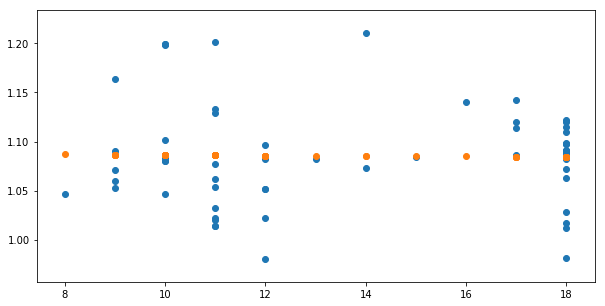

In [4]:
train([8,18],method='bottom',data=data)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':


模型误差为：0.006791
公式为y = -0.117049 * x^2 + 0.155801 * x + 0.954849


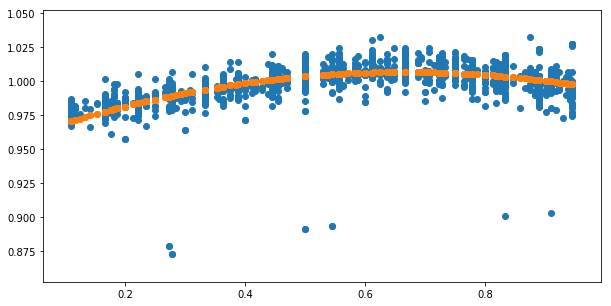

In [5]:
train([8,18],method='middle',data=data)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if sys.path[0] == '':


模型误差为：0.014209
公式为y = 0.000451 * x^2 + -0.012968 * x + 1.052876


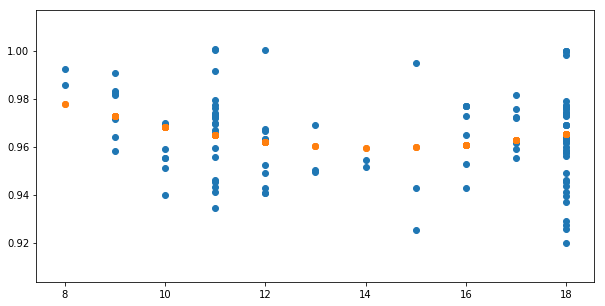

In [6]:
train([8,18],method='top',data=data)